###Projekt Sieci Neuronowe Dominik Ossowski

W tym projekcie zająłem się badaniem hipotezy:
"czy charakter przebiegu i zmian w sieci w każdym z godzinowych odcinków 
doby, zgodnie z czasem lokalnym, jest podobny do analogicznych odcinków w innych 
dobach, niezależnie od pory roku, wakacji itp."

In [242]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [145]:
!pip3 install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.3 MB/s eta 0:00:00


1. Pierwszym etapem projektu jest wczytanie danych i dokonanie ich analizy 

In [65]:
def load_zip(zip):
    df = pd.read_csv(zip)
    df.columns = ['time', 'value']
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df['value'] = df['value'].astype('float32')
    return df
    


In [71]:
zips = Path('drive/MyDrive/data1').glob('*.zip')
dfs = (load_zip(zip) for zip in zips)
df = pd.concat(dfs).set_index('time')
df = df.sort_index()


In [83]:
df.head()

,value
time,
2022-01-01 00:00:01.530,228.977997
2022-01-01 00:00:02.530,228.975006
2022-01-01 00:00:03.528,228.964996
2022-01-01 00:00:04.530,228.979004
2022-01-01 00:00:05.530,228.934006


In [7]:
def generate_day_plot(df):
    df = df
    df_grouped = df.groupby([df.index.minute, df.index.hour]).mean().unstack()['value']
    df_day = pd.concat([df_grouped[i] for i in range(24)]).reset_index(drop=True)
    df_day.index = pd.to_timedelta(df_day.index, unit='m')
    df_day.plot(kind='line', figsize=(20, 5))
    print(df)
    print(df.info())

Funkcja generate_day_plot przyjmuje obiekt DataFrame df i generuje wykres liniowy, który przedstawia średnie wartości dla każdej minuty w ciągu całego dnia. Funkcja grupuje dane według godziny i minuty, oblicza średnie wartości dla każdej grupy, a następnie generuje wykres liniowy. Na końcu wyświetlane są informacje o przekazanym obiekcie DataFrame df.

                              value
time                               
2022-01-01 00:00:01.530  228.977997
2022-01-01 00:00:02.530  228.975006
2022-01-01 00:00:03.528  228.964996
2022-01-01 00:00:04.530  228.979004
2022-01-01 00:00:05.530  228.934006
...                             ...
2022-12-31 23:59:55.154  230.076996
2022-12-31 23:59:56.154  230.121994
2022-12-31 23:59:57.153  230.123993
2022-12-31 23:59:58.152  230.141998
2022-12-31 23:59:59.152  230.143997

[31485233 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31485233 entries, 2022-01-01 00:00:01.530000 to 2022-12-31 23:59:59.152000
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   value   float32
dtypes: float32(1)
memory usage: 360.3 MB
None


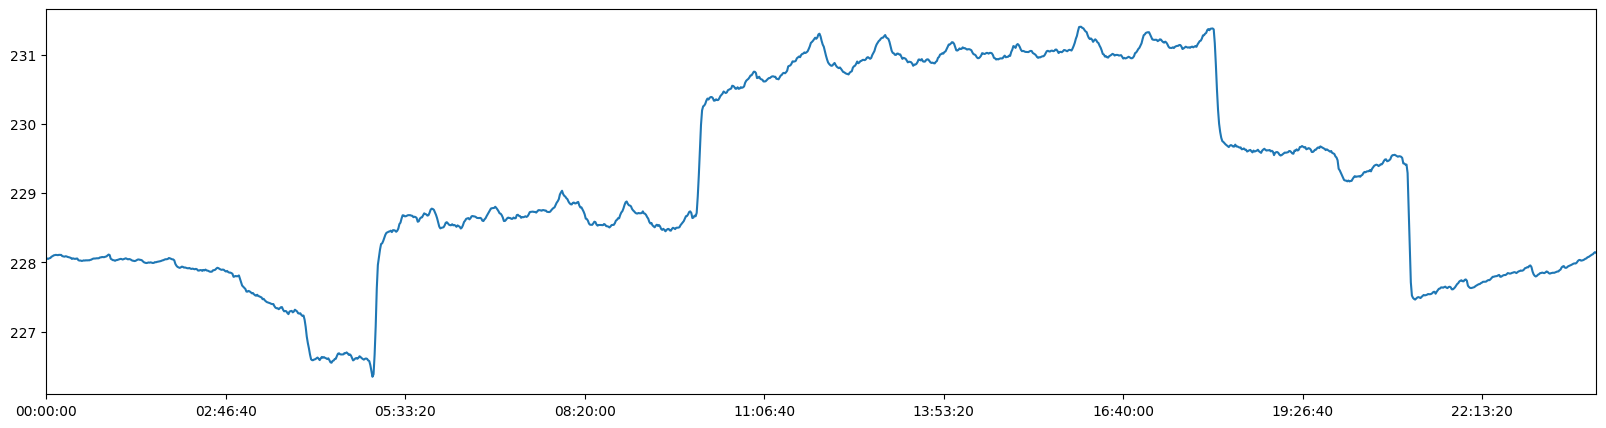

In [8]:
generate_day_plot(df)

Rozkład napięcia w ciągu jednego dnia

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31485233 entries, 2022-01-01 00:00:01.530000 to 2022-12-31 23:59:59.152000
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   value   float32
dtypes: float32(1)
memory usage: 360.3 MB


<Axes: >

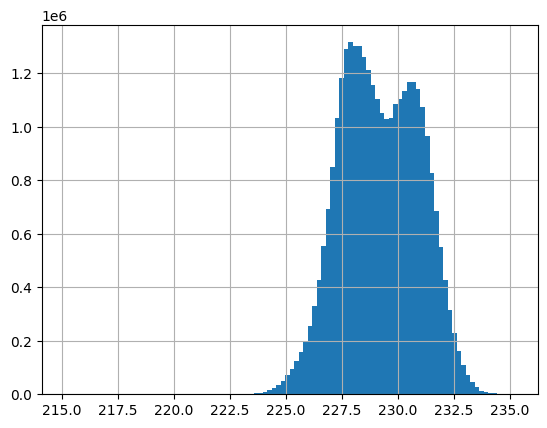

In [11]:
df['value'].hist(bins=100)

2. Drugim etapem projektu jest sprawdzanie hipotezy używając technik uczenia maszynowego. Przeszukując dostępne źródła nie natknąłem się na żadne rozwiązania. Wygląda na to, że tym rodzajem problemu nikt się jeszcze nie zajmował, albo zajmował, ale nie udostępnił wyników. Wracając do użytych technik, wywnioskowałem, że muszą istnieć 2 podejścia do time series dataset:

 1. Domyślna - regresja
 2. Zrezygnowanie z aspektu szeregu czasowego danych i stworzenie klasyfikacji

Regresja jest powszechnie używaną techniką radzenia sobie z time series data i dzieli się na 2 modele:

    1. RNN (a dokładnie LSTM)
    2. Regresja liniowa

Klasyfikacja zakłada rezygnację z szeregowości czasowej danych i bierze pod uwagę 24 klasy po 3600 wierszy danych. 


2a. LSTM

In [12]:
df.isnull().values.any()

False

In [84]:
df_resampled = df.resample('1h').mean()

In [85]:
df_resampled.head()

,value
time,
2022-01-01 00:00:00,229.130783
2022-01-01 01:00:00,229.179276
2022-01-01 02:00:00,229.599426
2022-01-01 03:00:00,229.603622
2022-01-01 04:00:00,229.962280


In [15]:
df_resampled.isnull().values.any()

True

In [16]:
df_resampled['value'].fillna(method='ffill', inplace=True)

In [17]:
df_resampled.isnull().values.any()

False

Aby dane nadawały się do treningu należy sprowadzić timestampy do rónych odległości w czasie (w moim przypadku do 1 godziny) - do tego służy metoda .resample(). Funkcja ta produkuje niestety wartości null, które należy zastąpić za pomocą metody .fillna().  

Przygotowanie danych do treningu

In [29]:
train_size = int(len(df_resampled) * 0.8)
train_data = df_resampled.iloc[:train_size]
test_data = df_resampled.iloc[train_size:]

In [30]:
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i+sequence_length+1]
        sequences.append(sequence)
    return sequences

Ten fragment kodu obejmuje dwie operacje.

Pierwsza operacja to podział zbioru danych df_resampled na zbiory treningowy i testowy. Zbiór treningowy stanowi 80% danych, a zbiór testowy to pozostałe 20%.

Druga operacja definiuje funkcję create_sequences, która służy do tworzenia sekwencji danych. Funkcja przyjmuje dane i długość sekwencji. Następnie iteruje przez dane i tworzy sekwencje o zadanej długości, dodając do nich jeden dodatkowy element. Utworzone sekwencje są zwracane jako wynik funkcji.

In [31]:
sequence_length = 3 
train_sequences = create_sequences(train_data['value'].values, sequence_length)
test_sequences = create_sequences(test_data['value'].values, sequence_length)

In [32]:
def split_sequences(sequences):
    X = []
    y = []
    for sequence in sequences:
        X.append(sequence[:-1])
        y.append(sequence[-1])
    return np.array(X), np.array(y)

X_train, y_train = split_sequences(train_sequences)
X_test, y_test = split_sequences(test_sequences)

Ten fragment kodu zawiera operacje związane z tworzeniem sekwencji danych i podziałem ich na zestawy treningowe i testowe:

sequence_length = 3: Ustalenie długości sekwencji na 3.

train_sequences = create_sequences(train_data['value'].values, sequence_length): Tworzenie sekwencji treningowych na podstawie wartości kolumny 'value' ze zbioru treningowego.

test_sequences = create_sequences(test_data['value'].values, sequence_length): Tworzenie sekwencji testowych na podstawie wartości kolumny 'value' ze zbioru testowego.

split_sequences(sequences): Funkcja, która przyjmuje sekwencje danych i dzieli je na cechy (X) i etykiety (y).

X_train, y_train = split_sequences(train_sequences): Podział sekwencji treningowych na cechy treningowe (X_train) i etykiety treningowe (y_train).

X_test, y_test = split_sequences(test_sequences): Podział sekwencji testowych na cechy testowe (X_test) i etykiety testowe (y_test).

In [35]:
X_train.shape


(7005, 3)

In [36]:
y_train.shape

(7005,)

In [55]:
model10 = Sequential()
model10.add(InputLayer(input_shape=(sequence_length, 1)))
model10.add(LSTM(64,return_sequences=False))
model10.add(Dense(8, 'relu'))
model10.add(Dense(1, 'linear'))

model10.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


Model model10 jest sekwencyjnym modelem sieci neuronowej, który składa się z warstwy wejściowej o kształcie (sequence_length, 1), jednej warstwy LSTM z 64 jednostkami, dwóch warstw gęstych z funkcją aktywacji ReLU i jednej warstwy wyjściowej. Model ten ma łącznie 9 parametrów do trenowania.

In [56]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model10.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [57]:
history = model10.fit(X_train, y_train, epochs=100, callbacks=[cp1])

Epoch 1/100
213/219 [============================>.] - ETA: 0s - loss: 46031.8984 - root_mean_squared_error: 214.5505

219/219 [==============================] - 4s 5ms/step - loss: 45827.3438 - root_mean_squared_error: 214.0732
Epoch 2/100
216/219 [============================>.] - ETA: 0s - loss: 29190.4473 - root_mean_squared_error: 170.8521

219/219 [==============================] - 1s 5ms/step - loss: 29070.2578 - root_mean_squared_error: 170.5000
Epoch 3/100
214/219 [============================>.] - ETA: 0s - loss: 12404.9561 - root_mean_squared_error: 111.3775

219/219 [==============================] - 1s 4ms/step - loss: 12263.1035 - root_mean_squared_error: 110.7389
Epoch 4/100
212/219 [============================>.] - ETA: 0s - loss: 2740.6743 - root_mean_squared_error: 52.3515

219/219 [==============================] - 1s 4ms/step - loss: 2676.3745 - root_mean_squared_error: 51.7337
Epoch 5/100
211/219 [===========================>..] - ETA: 0s - loss: 226.4625 - root_mean_squared_error: 15.0487

219/219 [==============================] - 1s 4ms/step - loss: 219.5103 - root_mean_squared_error: 14.8159
Epoch 6/100
219/219 [==============================] - ETA: 0s - loss: 10.7151 - root_mean_squared_error: 3.2734

219/219 [==============================] - 1s 5ms/step - loss: 10.7151 - root_mean_squared_error: 3.2734
Epoch 7/100
209/219 [===========================>..] - ETA: 0s - loss: 2.8153 - root_mean_squared_error: 1.6779

219/219 [==============================] - 1s 5ms/step - loss: 2.8249 - root_mean_squared_error: 1.6807
Epoch 8/100
208/219 [===========================>..] - ETA: 0s - loss: 2.8130 - root_mean_squared_error: 1.6772

219/219 [==============================] - 1s 5ms/step - loss: 2.8040 - root_mean_squared_error: 1.6745
Epoch 9/100
212/219 [============================>.] - ETA: 0s - loss: 2.7959 - root_mean_squared_error: 1.6721

219/219 [==============================] - 1s 5ms/step - loss: 2.8039 - root_mean_squared_error: 1.6745
Epoch 10/100
214/219 [============================>.] - ETA: 0s - loss: 2.8020 - root_mean_squared_error: 1.6739

219/219 [==============================] - 1s 7ms/step - loss: 2.8034 - root_mean_squared_error: 1.6743
Epoch 11/100
217/219 [============================>.] - ETA: 0s - loss: 2.8054 - root_mean_squared_error: 1.6749

219/219 [==============================] - 2s 7ms/step - loss: 2.8046 - root_mean_squared_error: 1.6747
Epoch 12/100
210/219 [===========================>..] - ETA: 0s - loss: 2.8063 - root_mean_squared_error: 1.6752

219/219 [==============================] - 1s 7ms/step - loss: 2.8039 - root_mean_squared_error: 1.6745
Epoch 13/100
218/219 [============================>.] - ETA: 0s - loss: 2.8030 - root_mean_squared_error: 1.6742

219/219 [==============================] - 1s 5ms/step - loss: 2.8038 - root_mean_squared_error: 1.6744
Epoch 14/100
216/219 [============================>.] - ETA: 0s - loss: 2.7995 - root_mean_squared_error: 1.6732

219/219 [==============================] - 1s 5ms/step - loss: 2.8044 - root_mean_squared_error: 1.6746
Epoch 15/100
210/219 [===========================>..] - ETA: 0s - loss: 2.8016 - root_mean_squared_error: 1.6738

219/219 [==============================] - 1s 5ms/step - loss: 2.8042 - root_mean_squared_error: 1.6746
Epoch 16/100
216/219 [============================>.] - ETA: 0s - loss: 2.8044 - root_mean_squared_error: 1.6746

219/219 [==============================] - 1s 4ms/step - loss: 2.8044 - root_mean_squared_error: 1.6746
Epoch 17/100
210/219 [===========================>..] - ETA: 0s - loss: 2.7837 - root_mean_squared_error: 1.6685

219/219 [==============================] - 1s 4ms/step - loss: 2.8052 - root_mean_squared_error: 1.6749
Epoch 18/100
216/219 [============================>.] - ETA: 0s - loss: 2.8025 - root_mean_squared_error: 1.6741

219/219 [==============================] - 1s 5ms/step - loss: 2.8053 - root_mean_squared_error: 1.6749
Epoch 19/100
216/219 [============================>.] - ETA: 0s - loss: 2.8088 - root_mean_squared_error: 1.6760

219/219 [==============================] - 1s 5ms/step - loss: 2.8062 - root_mean_squared_error: 1.6752
Epoch 20/100
219/219 [==============================] - ETA: 0s - loss: 2.8052 - root_mean_squared_error: 1.6749

219/219 [==============================] - 1s 5ms/step - loss: 2.8052 - root_mean_squared_error: 1.6749
Epoch 21/100
219/219 [==============================] - ETA: 0s - loss: 2.8063 - root_mean_squared_error: 1.6752

219/219 [==============================] - 1s 5ms/step - loss: 2.8063 - root_mean_squared_error: 1.6752
Epoch 22/100
213/219 [============================>.] - ETA: 0s - loss: 2.8144 - root_mean_squared_error: 1.6776

219/219 [==============================] - 1s 6ms/step - loss: 2.8077 - root_mean_squared_error: 1.6756
Epoch 23/100
219/219 [==============================] - ETA: 0s - loss: 2.8083 - root_mean_squared_error: 1.6758

219/219 [==============================] - 2s 7ms/step - loss: 2.8083 - root_mean_squared_error: 1.6758
Epoch 24/100
219/219 [==============================] - ETA: 0s - loss: 2.8078 - root_mean_squared_error: 1.6757

219/219 [==============================] - 2s 7ms/step - loss: 2.8078 - root_mean_squared_error: 1.6757
Epoch 25/100
211/219 [===========================>..] - ETA: 0s - loss: 2.8010 - root_mean_squared_error: 1.6736

219/219 [==============================] - 1s 6ms/step - loss: 2.8083 - root_mean_squared_error: 1.6758
Epoch 26/100
217/219 [============================>.] - ETA: 0s - loss: 2.8054 - root_mean_squared_error: 1.6749

219/219 [==============================] - 1s 5ms/step - loss: 2.8062 - root_mean_squared_error: 1.6752
Epoch 27/100
212/219 [============================>.] - ETA: 0s - loss: 2.8024 - root_mean_squared_error: 1.6740

219/219 [==============================] - 1s 4ms/step - loss: 2.8099 - root_mean_squared_error: 1.6763
Epoch 28/100
211/219 [===========================>..] - ETA: 0s - loss: 2.7999 - root_mean_squared_error: 1.6733

219/219 [==============================] - 1s 5ms/step - loss: 2.8068 - root_mean_squared_error: 1.6753
Epoch 29/100
211/219 [===========================>..] - ETA: 0s - loss: 2.8155 - root_mean_squared_error: 1.6780

219/219 [==============================] - 1s 5ms/step - loss: 2.8122 - root_mean_squared_error: 1.6769
Epoch 30/100
211/219 [===========================>..] - ETA: 0s - loss: 2.8015 - root_mean_squared_error: 1.6738

219/219 [==============================] - 1s 5ms/step - loss: 2.8081 - root_mean_squared_error: 1.6757
Epoch 31/100
212/219 [============================>.] - ETA: 0s - loss: 2.8238 - root_mean_squared_error: 1.6804

219/219 [==============================] - 1s 5ms/step - loss: 2.8163 - root_mean_squared_error: 1.6782
Epoch 32/100
209/219 [===========================>..] - ETA: 0s - loss: 2.8183 - root_mean_squared_error: 1.6788

219/219 [==============================] - 1s 5ms/step - loss: 2.8107 - root_mean_squared_error: 1.6765
Epoch 33/100
215/219 [============================>.] - ETA: 0s - loss: 2.8098 - root_mean_squared_error: 1.6763

219/219 [==============================] - 1s 5ms/step - loss: 2.8143 - root_mean_squared_error: 1.6776
Epoch 34/100
213/219 [============================>.] - ETA: 0s - loss: 2.8178 - root_mean_squared_error: 1.6786

219/219 [==============================] - 1s 5ms/step - loss: 2.8145 - root_mean_squared_error: 1.6777
Epoch 35/100
215/219 [============================>.] - ETA: 0s - loss: 2.8150 - root_mean_squared_error: 1.6778

219/219 [==============================] - 2s 7ms/step - loss: 2.8099 - root_mean_squared_error: 1.6763
Epoch 36/100
218/219 [============================>.] - ETA: 0s - loss: 2.8062 - root_mean_squared_error: 1.6752

219/219 [==============================] - 2s 7ms/step - loss: 2.8054 - root_mean_squared_error: 1.6749
Epoch 37/100
215/219 [============================>.] - ETA: 0s - loss: 2.8182 - root_mean_squared_error: 1.6788

219/219 [==============================] - 1s 6ms/step - loss: 2.8179 - root_mean_squared_error: 1.6787
Epoch 38/100
208/219 [===========================>..] - ETA: 0s - loss: 2.8228 - root_mean_squared_error: 1.6801

219/219 [==============================] - 1s 5ms/step - loss: 2.8166 - root_mean_squared_error: 1.6783
Epoch 39/100
212/219 [============================>.] - ETA: 0s - loss: 2.8254 - root_mean_squared_error: 1.6809

219/219 [==============================] - 1s 5ms/step - loss: 2.8186 - root_mean_squared_error: 1.6789
Epoch 40/100
210/219 [===========================>..] - ETA: 0s - loss: 2.8273 - root_mean_squared_error: 1.6815

219/219 [==============================] - 1s 5ms/step - loss: 2.8262 - root_mean_squared_error: 1.6811
Epoch 41/100
211/219 [===========================>..] - ETA: 0s - loss: 2.8200 - root_mean_squared_error: 1.6793

219/219 [==============================] - 1s 5ms/step - loss: 2.8216 - root_mean_squared_error: 1.6797
Epoch 42/100
210/219 [===========================>..] - ETA: 0s - loss: 2.8222 - root_mean_squared_error: 1.6799

219/219 [==============================] - 1s 5ms/step - loss: 2.8242 - root_mean_squared_error: 1.6805
Epoch 43/100
217/219 [============================>.] - ETA: 0s - loss: 2.8288 - root_mean_squared_error: 1.6819

219/219 [==============================] - 1s 5ms/step - loss: 2.8196 - root_mean_squared_error: 1.6792
Epoch 44/100
217/219 [============================>.] - ETA: 0s - loss: 2.8201 - root_mean_squared_error: 1.6793

219/219 [==============================] - 1s 5ms/step - loss: 2.8218 - root_mean_squared_error: 1.6798
Epoch 45/100
217/219 [============================>.] - ETA: 0s - loss: 2.8133 - root_mean_squared_error: 1.6773

219/219 [==============================] - 1s 5ms/step - loss: 2.8175 - root_mean_squared_error: 1.6785
Epoch 46/100
216/219 [============================>.] - ETA: 0s - loss: 2.8403 - root_mean_squared_error: 1.6853

219/219 [==============================] - 1s 5ms/step - loss: 2.8424 - root_mean_squared_error: 1.6859
Epoch 47/100
212/219 [============================>.] - ETA: 0s - loss: 2.8408 - root_mean_squared_error: 1.6855

219/219 [==============================] - 1s 7ms/step - loss: 2.8335 - root_mean_squared_error: 1.6833
Epoch 48/100
218/219 [============================>.] - ETA: 0s - loss: 2.8627 - root_mean_squared_error: 1.6920

219/219 [==============================] - 1s 7ms/step - loss: 2.8653 - root_mean_squared_error: 1.6927
Epoch 49/100
216/219 [============================>.] - ETA: 0s - loss: 2.8404 - root_mean_squared_error: 1.6854

219/219 [==============================] - 2s 8ms/step - loss: 2.8356 - root_mean_squared_error: 1.6839
Epoch 50/100
218/219 [============================>.] - ETA: 0s - loss: 2.8472 - root_mean_squared_error: 1.6874

219/219 [==============================] - 2s 7ms/step - loss: 2.8449 - root_mean_squared_error: 1.6867
Epoch 51/100
217/219 [============================>.] - ETA: 0s - loss: 2.8590 - root_mean_squared_error: 1.6909

219/219 [==============================] - 1s 7ms/step - loss: 2.8592 - root_mean_squared_error: 1.6909
Epoch 52/100
210/219 [===========================>..] - ETA: 0s - loss: 2.8054 - root_mean_squared_error: 1.6749

219/219 [==============================] - 1s 5ms/step - loss: 2.8230 - root_mean_squared_error: 1.6802
Epoch 53/100
219/219 [==============================] - ETA: 0s - loss: 2.7805 - root_mean_squared_error: 1.6675

219/219 [==============================] - 1s 4ms/step - loss: 2.7805 - root_mean_squared_error: 1.6675
Epoch 54/100
214/219 [============================>.] - ETA: 0s - loss: 2.8334 - root_mean_squared_error: 1.6833

219/219 [==============================] - 1s 4ms/step - loss: 2.8189 - root_mean_squared_error: 1.6790
Epoch 55/100
213/219 [============================>.] - ETA: 0s - loss: 2.7999 - root_mean_squared_error: 1.6733

219/219 [==============================] - 1s 4ms/step - loss: 2.8033 - root_mean_squared_error: 1.6743
Epoch 56/100
209/219 [===========================>..] - ETA: 0s - loss: 2.7818 - root_mean_squared_error: 1.6679

219/219 [==============================] - 1s 4ms/step - loss: 2.7872 - root_mean_squared_error: 1.6695
Epoch 57/100
212/219 [============================>.] - ETA: 0s - loss: 2.7746 - root_mean_squared_error: 1.6657

219/219 [==============================] - 1s 4ms/step - loss: 2.7769 - root_mean_squared_error: 1.6664
Epoch 58/100
219/219 [==============================] - ETA: 0s - loss: 2.7196 - root_mean_squared_error: 1.6491

219/219 [==============================] - 1s 4ms/step - loss: 2.7196 - root_mean_squared_error: 1.6491
Epoch 59/100
213/219 [============================>.] - ETA: 0s - loss: 2.6606 - root_mean_squared_error: 1.6311

219/219 [==============================] - 1s 4ms/step - loss: 2.6593 - root_mean_squared_error: 1.6307
Epoch 60/100
206/219 [===========================>..] - ETA: 0s - loss: 2.7403 - root_mean_squared_error: 1.6554

219/219 [==============================] - 1s 4ms/step - loss: 2.7425 - root_mean_squared_error: 1.6561
Epoch 61/100
208/219 [===========================>..] - ETA: 0s - loss: 2.5676 - root_mean_squared_error: 1.6024

219/219 [==============================] - 1s 4ms/step - loss: 2.5675 - root_mean_squared_error: 1.6024
Epoch 62/100
215/219 [============================>.] - ETA: 0s - loss: 2.5337 - root_mean_squared_error: 1.5918

219/219 [==============================] - 1s 4ms/step - loss: 2.5345 - root_mean_squared_error: 1.5920
Epoch 63/100
218/219 [============================>.] - ETA: 0s - loss: 2.4288 - root_mean_squared_error: 1.5584

219/219 [==============================] - 1s 7ms/step - loss: 2.4311 - root_mean_squared_error: 1.5592
Epoch 64/100
216/219 [============================>.] - ETA: 0s - loss: 2.2161 - root_mean_squared_error: 1.4887

219/219 [==============================] - 1s 7ms/step - loss: 2.2125 - root_mean_squared_error: 1.4874
Epoch 65/100
214/219 [============================>.] - ETA: 0s - loss: 2.2106 - root_mean_squared_error: 1.4868

219/219 [==============================] - 1s 7ms/step - loss: 2.2077 - root_mean_squared_error: 1.4858
Epoch 66/100
217/219 [============================>.] - ETA: 0s - loss: 2.3057 - root_mean_squared_error: 1.5185

219/219 [==============================] - 1s 4ms/step - loss: 2.3040 - root_mean_squared_error: 1.5179
Epoch 67/100
215/219 [============================>.] - ETA: 0s - loss: 2.0999 - root_mean_squared_error: 1.4491

219/219 [==============================] - 1s 4ms/step - loss: 2.1017 - root_mean_squared_error: 1.4497
Epoch 68/100
213/219 [============================>.] - ETA: 0s - loss: 1.9285 - root_mean_squared_error: 1.3887

219/219 [==============================] - 1s 4ms/step - loss: 1.9214 - root_mean_squared_error: 1.3861
Epoch 69/100
212/219 [============================>.] - ETA: 0s - loss: 1.9755 - root_mean_squared_error: 1.4055

219/219 [==============================] - 1s 4ms/step - loss: 1.9800 - root_mean_squared_error: 1.4071
Epoch 70/100
207/219 [===========================>..] - ETA: 0s - loss: 1.7991 - root_mean_squared_error: 1.3413

219/219 [==============================] - 1s 4ms/step - loss: 1.8028 - root_mean_squared_error: 1.3427
Epoch 71/100
212/219 [============================>.] - ETA: 0s - loss: 1.6950 - root_mean_squared_error: 1.3019

219/219 [==============================] - 1s 4ms/step - loss: 1.7053 - root_mean_squared_error: 1.3059
Epoch 72/100
211/219 [===========================>..] - ETA: 0s - loss: 1.7159 - root_mean_squared_error: 1.3099

219/219 [==============================] - 1s 4ms/step - loss: 1.7181 - root_mean_squared_error: 1.3108
Epoch 73/100
210/219 [===========================>..] - ETA: 0s - loss: 1.7362 - root_mean_squared_error: 1.3176

219/219 [==============================] - 1s 4ms/step - loss: 1.7357 - root_mean_squared_error: 1.3175
Epoch 74/100
208/219 [===========================>..] - ETA: 0s - loss: 1.6335 - root_mean_squared_error: 1.2781

219/219 [==============================] - 1s 4ms/step - loss: 1.6349 - root_mean_squared_error: 1.2786
Epoch 75/100
210/219 [===========================>..] - ETA: 0s - loss: 1.5234 - root_mean_squared_error: 1.2343

219/219 [==============================] - 1s 4ms/step - loss: 1.5338 - root_mean_squared_error: 1.2385
Epoch 76/100
216/219 [============================>.] - ETA: 0s - loss: 1.4604 - root_mean_squared_error: 1.2085

219/219 [==============================] - 1s 4ms/step - loss: 1.4579 - root_mean_squared_error: 1.2075
Epoch 77/100
212/219 [============================>.] - ETA: 0s - loss: 1.4492 - root_mean_squared_error: 1.2038

219/219 [==============================] - 1s 6ms/step - loss: 1.4606 - root_mean_squared_error: 1.2086
Epoch 78/100
217/219 [============================>.] - ETA: 0s - loss: 1.4029 - root_mean_squared_error: 1.1844

219/219 [==============================] - 1s 6ms/step - loss: 1.4042 - root_mean_squared_error: 1.1850
Epoch 79/100
215/219 [============================>.] - ETA: 0s - loss: 1.4117 - root_mean_squared_error: 1.1881

219/219 [==============================] - 1s 5ms/step - loss: 1.4113 - root_mean_squared_error: 1.1880
Epoch 80/100
205/219 [===========================>..] - ETA: 0s - loss: 1.2996 - root_mean_squared_error: 1.1400

219/219 [==============================] - 1s 5ms/step - loss: 1.2891 - root_mean_squared_error: 1.1354
Epoch 81/100
205/219 [===========================>..] - ETA: 0s - loss: 1.4441 - root_mean_squared_error: 1.2017

219/219 [==============================] - 1s 4ms/step - loss: 1.4406 - root_mean_squared_error: 1.2003
Epoch 82/100
215/219 [============================>.] - ETA: 0s - loss: 1.4130 - root_mean_squared_error: 1.1887

219/219 [==============================] - 1s 4ms/step - loss: 1.4291 - root_mean_squared_error: 1.1954
Epoch 83/100
219/219 [==============================] - ETA: 0s - loss: 1.2643 - root_mean_squared_error: 1.1244

219/219 [==============================] - 1s 4ms/step - loss: 1.2643 - root_mean_squared_error: 1.1244
Epoch 84/100
208/219 [===========================>..] - ETA: 0s - loss: 1.3113 - root_mean_squared_error: 1.1451

219/219 [==============================] - 1s 4ms/step - loss: 1.3192 - root_mean_squared_error: 1.1486
Epoch 85/100
212/219 [============================>.] - ETA: 0s - loss: 1.2417 - root_mean_squared_error: 1.1143

219/219 [==============================] - 1s 4ms/step - loss: 1.2368 - root_mean_squared_error: 1.1121
Epoch 86/100
212/219 [============================>.] - ETA: 0s - loss: 1.3675 - root_mean_squared_error: 1.1694

219/219 [==============================] - 1s 4ms/step - loss: 1.3712 - root_mean_squared_error: 1.1710
Epoch 87/100
216/219 [============================>.] - ETA: 0s - loss: 1.2402 - root_mean_squared_error: 1.1136

219/219 [==============================] - 1s 4ms/step - loss: 1.2387 - root_mean_squared_error: 1.1130
Epoch 88/100
213/219 [============================>.] - ETA: 0s - loss: 1.3966 - root_mean_squared_error: 1.1818

219/219 [==============================] - 1s 4ms/step - loss: 1.3906 - root_mean_squared_error: 1.1792
Epoch 89/100
219/219 [==============================] - ETA: 0s - loss: 1.2082 - root_mean_squared_error: 1.0992

219/219 [==============================] - 1s 4ms/step - loss: 1.2082 - root_mean_squared_error: 1.0992
Epoch 90/100
218/219 [============================>.] - ETA: 0s - loss: 1.2403 - root_mean_squared_error: 1.1137

219/219 [==============================] - 1s 4ms/step - loss: 1.2410 - root_mean_squared_error: 1.1140
Epoch 91/100
214/219 [============================>.] - ETA: 0s - loss: 1.1443 - root_mean_squared_error: 1.0697

219/219 [==============================] - 1s 4ms/step - loss: 1.1484 - root_mean_squared_error: 1.0716
Epoch 92/100
216/219 [============================>.] - ETA: 0s - loss: 1.1421 - root_mean_squared_error: 1.0687

219/219 [==============================] - 1s 6ms/step - loss: 1.1456 - root_mean_squared_error: 1.0703
Epoch 93/100
215/219 [============================>.] - ETA: 0s - loss: 1.1423 - root_mean_squared_error: 1.0688

219/219 [==============================] - 1s 6ms/step - loss: 1.1436 - root_mean_squared_error: 1.0694
Epoch 94/100
211/219 [===========================>..] - ETA: 0s - loss: 1.3151 - root_mean_squared_error: 1.1468

219/219 [==============================] - 1s 6ms/step - loss: 1.3082 - root_mean_squared_error: 1.1438
Epoch 95/100
214/219 [============================>.] - ETA: 0s - loss: 1.3289 - root_mean_squared_error: 1.1528

219/219 [==============================] - 1s 6ms/step - loss: 1.3210 - root_mean_squared_error: 1.1493
Epoch 96/100
212/219 [============================>.] - ETA: 0s - loss: 1.3402 - root_mean_squared_error: 1.1577

219/219 [==============================] - 1s 4ms/step - loss: 1.3330 - root_mean_squared_error: 1.1545
Epoch 97/100
211/219 [===========================>..] - ETA: 0s - loss: 1.0779 - root_mean_squared_error: 1.0382

219/219 [==============================] - 1s 4ms/step - loss: 1.0782 - root_mean_squared_error: 1.0384
Epoch 98/100
215/219 [============================>.] - ETA: 0s - loss: 1.0284 - root_mean_squared_error: 1.0141

219/219 [==============================] - 1s 4ms/step - loss: 1.0292 - root_mean_squared_error: 1.0145
Epoch 99/100
218/219 [============================>.] - ETA: 0s - loss: 1.1813 - root_mean_squared_error: 1.0869

219/219 [==============================] - 1s 4ms/step - loss: 1.1790 - root_mean_squared_error: 1.0858
Epoch 100/100
217/219 [============================>.] - ETA: 0s - loss: 1.2033 - root_mean_squared_error: 1.0969

219/219 [==============================] - 1s 4ms/step - loss: 1.2005 - root_mean_squared_error: 1.0957


In [ ]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [ ]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

219/219 [==============================] - 0s 2ms/step


,Train Predictions,Actuals
0,229.156342,229.972504
1,229.156357,230.266754
2,229.156357,230.446320
3,229.156357,230.619217
4,229.156342,230.294601
...,...,...
6995,229.156357,230.094009
6996,229.156357,230.502975
6997,229.156357,229.392166
6998,229.156342,229.942551


In [ ]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

32/32 [==============================] - 0s 2ms/step


,Test Predictions,Actuals
0,229.156342,229.377472
1,229.156342,229.310104
2,229.156357,229.173431
3,229.156357,229.036972
4,229.156357,230.725174
...,...,...
995,229.156357,229.219894
996,229.156357,229.810226
997,229.156357,229.984299
998,229.156357,230.499542


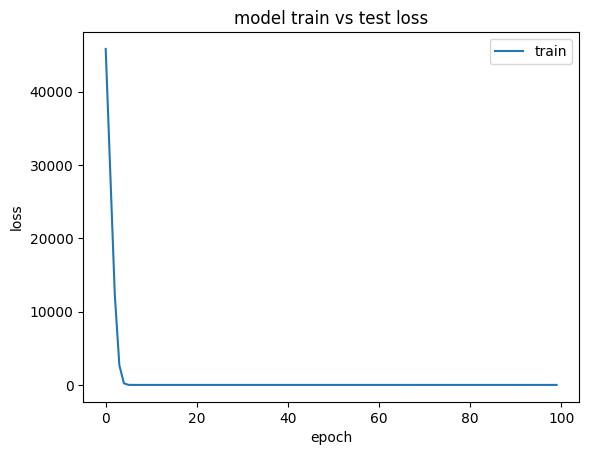

In [116]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'])
pyplot.title('model train vs test loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper right')
pyplot.show()

Model wytrenował się bardzo dobrze -> niski loss i predykcje zbliżone do wartości true. Niestey, nasz model nauczył się przewidiywać value na podstawie czasu, a nie na odwrót. Spowodowane jest to implementacją sieci lstm, która zawsze jako input przyjmuje dane zmnienione na szereg czasowy i przez to predykcja czasu od wartości jest niemożliwa w tym przypadku.  

2b. Regresja liniowa

Regresja liniowa może przyjąć szereg czasowy jako input, o ile jest on w formacie UNIX Timestamp i dokonywać predykcji z zadawalającą dokładnością.  

In [ ]:
df_resampled_c = df.resample('1h').mean()

In [97]:
df_resampled_c=df_resampled.reset_index('time')

In [98]:
df_resampled_c.head()

,time,value
0,2022-01-01 00:00:00,229.130783
1,2022-01-01 01:00:00,229.179276
2,2022-01-01 02:00:00,229.599426
3,2022-01-01 03:00:00,229.603622
4,2022-01-01 04:00:00,229.962280


In [102]:
df_resampled_c['time'] = df_resampled_c['time'].apply(lambda x: int(datetime.timestamp(x)))

In [103]:
df_resampled_c.head()

,time,value
0,1640995200,229.130783
1,1640998800,229.179276
2,1641002400,229.599426
3,1641006000,229.603622
4,1641009600,229.962280


In [105]:
X = df_resampled_c[['value']] 
y = df_resampled_c['time'] 

W tym przypadku po operacji resamplingu musiałem "wyciągnać" dane o czasie z indeksu i zamienić je na unixowy format, ponieważ LinearRegression() nie przyjmuje innych formatów czasu. 

In [106]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y, test_size=0.1)

In [107]:
model = LinearRegression()
model.fit(X_train_c, y_train_c)

LinearRegression()

In [113]:
y_pred = model.predict(X_test_c)

r2_scored = r2_score(y_test_c, y_pred)
r2_scored

0.0027106549875104413

W tym przypadku ciężo ocenić model, ponieważ nie normalizowałem danych, aby nie stracić interpretowalności i przez to r^2 nie jest najlepszą miarą jakości. 

In [111]:
new_data = pd.DataFrame({'value': [228]})
predicted_timestamp = model.predict(new_data)
predicted_timestamp

array([1.65748045e+09])

https://www.epochconverter.com/

Według tego konwertera model przewidział godzinę 21

Jak widać regresja liniowa poradziła sobie z tym zdaniem i udało mi się przewidzieć godzinę na podstawie wartości napięcia fazy.

2c. Klasyfikacja

In [219]:
zips1 = Path('drive/MyDrive/data1').glob('*.zip')
dfs1 = (load_zip(zip) for zip in zips1)
df1 = pd.concat(dfs1).set_index('time')
df1 = df.sort_index()

In [220]:
df_resampled_k = df1.resample('1h').mean()

In [221]:
df_resampled_k.isnull().values.any()

True

In [222]:
df_resampled_k['value'].fillna(method='ffill', inplace=True)

In [223]:
df_resampled_k.isnull().values.any()

False

In [224]:
df_resampled_k

,value
time,
2022-01-01 00:00:00,229.130783
2022-01-01 01:00:00,229.179276
2022-01-01 02:00:00,229.599426
2022-01-01 03:00:00,229.603622
2022-01-01 04:00:00,229.962280
...,...
2022-12-31 19:00:00,229.219894
2022-12-31 20:00:00,229.810226
2022-12-31 21:00:00,229.984299


In [225]:
df_resampled_k['class'] = df_resampled_k.index.hour

In [226]:
df_resampled_k.shape

(8760, 2)

Utworzyłem dodatkową kolumnę 'class' w której przechowuję informację o klasie wartości napięcia. Klas jest 24 - jedna na każdą godzinę. 

In [237]:
X1 = df_resampled_k['value'].values
y1 = df_resampled_k['class'].values

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.1, random_state=42)

scaler = StandardScaler()
X1_train = scaler.fit_transform(X1_train.reshape(-1, 1))
X1_test = scaler.transform(X1_test.reshape(-1, 1))

num_classes = len(np.unique(y1_train))

y1_train = to_categorical(y1_train, num_classes)
y1_test = to_categorical(y1_test, num_classes)


Dane zostały znormalizowane i przygotowane do wprowadzenia do modelu.

In [238]:
num_classes

24

In [239]:
X1_train.shape

(7884, 1)

In [240]:
y1_train.shape

(7884, 24)

In [241]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(1,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

cp2 = ModelCheckpoint('model2/', save_best_only=True)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy',tfa.metrics.F1Score(num_classes=24,
                                                  average='macro',
                                                  threshold=0.5)])

model.fit(X1_train, y1_train, epochs=50, callbacks=[cp2])

Epoch 1/50
235/247 [===========================>..] - ETA: 0s - loss: 2.8625 - accuracy: 0.0896 - f1_score: 0.0000e+00

247/247 [==============================] - 1s 2ms/step - loss: 2.8536 - accuracy: 0.0897 - f1_score: 0.0000e+00
Epoch 2/50
235/247 [===========================>..] - ETA: 0s - loss: 2.6140 - accuracy: 0.1150 - f1_score: 0.0011    

247/247 [==============================] - 0s 2ms/step - loss: 2.6147 - accuracy: 0.1154 - f1_score: 0.0010
Epoch 3/50
232/247 [===========================>..] - ETA: 0s - loss: 2.5718 - accuracy: 0.1257 - f1_score: 0.0065

247/247 [==============================] - 0s 2ms/step - loss: 2.5738 - accuracy: 0.1266 - f1_score: 0.0078
Epoch 4/50
223/247 [==========================>...] - ETA: 0s - loss: 2.5596 - accuracy: 0.1282 - f1_score: 0.0133

247/247 [==============================] - 0s 2ms/step - loss: 2.5604 - accuracy: 0.1294 - f1_score: 0.0143
Epoch 5/50
231/247 [===========================>..] - ETA: 0s - loss: 2.5563 - accuracy: 0.1308 - f1_score: 0.0172

247/247 [==============================] - 0s 2ms/step - loss: 2.5567 - accuracy: 0.1309 - f1_score: 0.0176
Epoch 6/50
240/247 [============================>.] - ETA: 0s - loss: 2.5516 - accuracy: 0.1267 - f1_score: 0.0178

247/247 [==============================] - 0s 2ms/step - loss: 2.5532 - accuracy: 0.1266 - f1_score: 0.0176
Epoch 7/50
226/247 [==========================>...] - ETA: 0s - loss: 2.5559 - accuracy: 0.1325 - f1_score: 0.0184

247/247 [==============================] - 0s 2ms/step - loss: 2.5526 - accuracy: 0.1343 - f1_score: 0.0187
Epoch 8/50
244/247 [============================>.] - ETA: 0s - loss: 2.5534 - accuracy: 0.1313 - f1_score: 0.0178

247/247 [==============================] - 0s 2ms/step - loss: 2.5519 - accuracy: 0.1318 - f1_score: 0.0178
Epoch 9/50
238/247 [===========================>..] - ETA: 0s - loss: 2.5527 - accuracy: 0.1338 - f1_score: 0.0190

247/247 [==============================] - 0s 2ms/step - loss: 2.5506 - accuracy: 0.1329 - f1_score: 0.0191
Epoch 10/50
240/247 [============================>.] - ETA: 0s - loss: 2.5499 - accuracy: 0.1376 - f1_score: 0.0198

247/247 [==============================] - 0s 2ms/step - loss: 2.5512 - accuracy: 0.1379 - f1_score: 0.0196
Epoch 11/50
236/247 [===========================>..] - ETA: 0s - loss: 2.5495 - accuracy: 0.1314 - f1_score: 0.0196

247/247 [==============================] - 0s 2ms/step - loss: 2.5495 - accuracy: 0.1313 - f1_score: 0.0196
Epoch 12/50
232/247 [===========================>..] - ETA: 0s - loss: 2.5490 - accuracy: 0.1325 - f1_score: 0.0203

247/247 [==============================] - 0s 2ms/step - loss: 2.5486 - accuracy: 0.1328 - f1_score: 0.0200
Epoch 13/50
237/247 [===========================>..] - ETA: 0s - loss: 2.5478 - accuracy: 0.1329 - f1_score: 0.0201

247/247 [==============================] - 0s 2ms/step - loss: 2.5469 - accuracy: 0.1324 - f1_score: 0.0201
Epoch 14/50
233/247 [===========================>..] - ETA: 0s - loss: 2.5488 - accuracy: 0.1318 - f1_score: 0.0199

247/247 [==============================] - 0s 2ms/step - loss: 2.5485 - accuracy: 0.1334 - f1_score: 0.0202
Epoch 15/50
232/247 [===========================>..] - ETA: 0s - loss: 2.5476 - accuracy: 0.1342 - f1_score: 0.0201

247/247 [==============================] - 0s 2ms/step - loss: 2.5478 - accuracy: 0.1334 - f1_score: 0.0200
Epoch 16/50
227/247 [==========================>...] - ETA: 0s - loss: 2.5420 - accuracy: 0.1410 - f1_score: 0.0204

247/247 [==============================] - 0s 2ms/step - loss: 2.5486 - accuracy: 0.1389 - f1_score: 0.0200
Epoch 17/50
236/247 [===========================>..] - ETA: 0s - loss: 2.5451 - accuracy: 0.1315 - f1_score: 0.0204

247/247 [==============================] - 0s 2ms/step - loss: 2.5455 - accuracy: 0.1327 - f1_score: 0.0205
Epoch 18/50
237/247 [===========================>..] - ETA: 0s - loss: 2.5459 - accuracy: 0.1337 - f1_score: 0.0205

247/247 [==============================] - 1s 2ms/step - loss: 2.5471 - accuracy: 0.1337 - f1_score: 0.0203
Epoch 19/50
245/247 [============================>.] - ETA: 0s - loss: 2.5466 - accuracy: 0.1347 - f1_score: 0.0198

247/247 [==============================] - 1s 3ms/step - loss: 2.5463 - accuracy: 0.1342 - f1_score: 0.0198
Epoch 20/50
229/247 [==========================>...] - ETA: 0s - loss: 2.5463 - accuracy: 0.1339 - f1_score: 0.0208

247/247 [==============================] - 1s 2ms/step - loss: 2.5465 - accuracy: 0.1350 - f1_score: 0.0207
Epoch 21/50
237/247 [===========================>..] - ETA: 0s - loss: 2.5481 - accuracy: 0.1383 - f1_score: 0.0206

247/247 [==============================] - 1s 2ms/step - loss: 2.5455 - accuracy: 0.1390 - f1_score: 0.0207
Epoch 22/50
227/247 [==========================>...] - ETA: 0s - loss: 2.5447 - accuracy: 0.1320 - f1_score: 0.0196

247/247 [==============================] - 1s 3ms/step - loss: 2.5446 - accuracy: 0.1329 - f1_score: 0.0203
Epoch 23/50
231/247 [===========================>..] - ETA: 0s - loss: 2.5437 - accuracy: 0.1353 - f1_score: 0.0207

247/247 [==============================] - 1s 3ms/step - loss: 2.5456 - accuracy: 0.1365 - f1_score: 0.0205
Epoch 24/50
236/247 [===========================>..] - ETA: 0s - loss: 2.5443 - accuracy: 0.1316 - f1_score: 0.0208

247/247 [==============================] - 1s 2ms/step - loss: 2.5463 - accuracy: 0.1313 - f1_score: 0.0205
Epoch 25/50
243/247 [============================>.] - ETA: 0s - loss: 2.5451 - accuracy: 0.1359 - f1_score: 0.0201

247/247 [==============================] - 1s 3ms/step - loss: 2.5446 - accuracy: 0.1360 - f1_score: 0.0199
Epoch 26/50
242/247 [============================>.] - ETA: 0s - loss: 2.5448 - accuracy: 0.1322 - f1_score: 0.0204

247/247 [==============================] - 0s 2ms/step - loss: 2.5443 - accuracy: 0.1322 - f1_score: 0.0205
Epoch 27/50
228/247 [==========================>...] - ETA: 0s - loss: 2.5458 - accuracy: 0.1342 - f1_score: 0.0207

247/247 [==============================] - 0s 2ms/step - loss: 2.5450 - accuracy: 0.1341 - f1_score: 0.0205
Epoch 28/50
235/247 [===========================>..] - ETA: 0s - loss: 2.5460 - accuracy: 0.1366 - f1_score: 0.0198

247/247 [==============================] - 0s 2ms/step - loss: 2.5442 - accuracy: 0.1367 - f1_score: 0.0198
Epoch 29/50
241/247 [============================>.] - ETA: 0s - loss: 2.5433 - accuracy: 0.1324 - f1_score: 0.0209

247/247 [==============================] - 0s 2ms/step - loss: 2.5445 - accuracy: 0.1315 - f1_score: 0.0207
Epoch 30/50
237/247 [===========================>..] - ETA: 0s - loss: 2.5456 - accuracy: 0.1344 - f1_score: 0.0200

247/247 [==============================] - 0s 2ms/step - loss: 2.5447 - accuracy: 0.1352 - f1_score: 0.0199
Epoch 31/50
228/247 [==========================>...] - ETA: 0s - loss: 2.5448 - accuracy: 0.1336 - f1_score: 0.0198

247/247 [==============================] - 0s 2ms/step - loss: 2.5444 - accuracy: 0.1338 - f1_score: 0.0203
Epoch 32/50
236/247 [===========================>..] - ETA: 0s - loss: 2.5472 - accuracy: 0.1353 - f1_score: 0.0205

247/247 [==============================] - 0s 2ms/step - loss: 2.5450 - accuracy: 0.1347 - f1_score: 0.0202
Epoch 33/50
230/247 [==========================>...] - ETA: 0s - loss: 2.5417 - accuracy: 0.1359 - f1_score: 0.0204

247/247 [==============================] - 0s 2ms/step - loss: 2.5429 - accuracy: 0.1357 - f1_score: 0.0203
Epoch 34/50
232/247 [===========================>..] - ETA: 0s - loss: 2.5434 - accuracy: 0.1334 - f1_score: 0.0210

247/247 [==============================] - 0s 2ms/step - loss: 2.5439 - accuracy: 0.1329 - f1_score: 0.0206
Epoch 35/50
235/247 [===========================>..] - ETA: 0s - loss: 2.5439 - accuracy: 0.1380 - f1_score: 0.0207

247/247 [==============================] - 0s 2ms/step - loss: 2.5428 - accuracy: 0.1374 - f1_score: 0.0205
Epoch 36/50
222/247 [=========================>....] - ETA: 0s - loss: 2.5454 - accuracy: 0.1322 - f1_score: 0.0206

247/247 [==============================] - 0s 2ms/step - loss: 2.5432 - accuracy: 0.1317 - f1_score: 0.0204
Epoch 37/50
235/247 [===========================>..] - ETA: 0s - loss: 2.5444 - accuracy: 0.1364 - f1_score: 0.0202

247/247 [==============================] - 0s 2ms/step - loss: 2.5438 - accuracy: 0.1361 - f1_score: 0.0201
Epoch 38/50
227/247 [==========================>...] - ETA: 0s - loss: 2.5416 - accuracy: 0.1375 - f1_score: 0.0195

247/247 [==============================] - 0s 2ms/step - loss: 2.5434 - accuracy: 0.1360 - f1_score: 0.0198
Epoch 39/50
232/247 [===========================>..] - ETA: 0s - loss: 2.5419 - accuracy: 0.1329 - f1_score: 0.0212

247/247 [==============================] - 0s 2ms/step - loss: 2.5434 - accuracy: 0.1334 - f1_score: 0.0208
Epoch 40/50
238/247 [===========================>..] - ETA: 0s - loss: 2.5395 - accuracy: 0.1337 - f1_score: 0.0191

247/247 [==============================] - 0s 2ms/step - loss: 2.5420 - accuracy: 0.1334 - f1_score: 0.0192
Epoch 41/50
233/247 [===========================>..] - ETA: 0s - loss: 2.5472 - accuracy: 0.1320 - f1_score: 0.0200

247/247 [==============================] - 0s 2ms/step - loss: 2.5440 - accuracy: 0.1332 - f1_score: 0.0198
Epoch 42/50
230/247 [==========================>...] - ETA: 0s - loss: 2.5429 - accuracy: 0.1342 - f1_score: 0.0203

247/247 [==============================] - 0s 2ms/step - loss: 2.5422 - accuracy: 0.1339 - f1_score: 0.0205
Epoch 43/50
237/247 [===========================>..] - ETA: 0s - loss: 2.5441 - accuracy: 0.1370 - f1_score: 0.0208

247/247 [==============================] - 0s 2ms/step - loss: 2.5422 - accuracy: 0.1379 - f1_score: 0.0206
Epoch 44/50
233/247 [===========================>..] - ETA: 0s - loss: 2.5466 - accuracy: 0.1373 - f1_score: 0.0203

247/247 [==============================] - 0s 2ms/step - loss: 2.5435 - accuracy: 0.1370 - f1_score: 0.0204
Epoch 45/50
224/247 [==========================>...] - ETA: 0s - loss: 2.5431 - accuracy: 0.1341 - f1_score: 0.0196

247/247 [==============================] - 0s 2ms/step - loss: 2.5417 - accuracy: 0.1343 - f1_score: 0.0205
Epoch 46/50
234/247 [===========================>..] - ETA: 0s - loss: 2.5415 - accuracy: 0.1317 - f1_score: 0.0201

247/247 [==============================] - 0s 2ms/step - loss: 2.5420 - accuracy: 0.1322 - f1_score: 0.0207
Epoch 47/50
227/247 [==========================>...] - ETA: 0s - loss: 2.5436 - accuracy: 0.1352 - f1_score: 0.0208

247/247 [==============================] - 0s 2ms/step - loss: 2.5428 - accuracy: 0.1358 - f1_score: 0.0205
Epoch 48/50
242/247 [============================>.] - ETA: 0s - loss: 2.5418 - accuracy: 0.1335 - f1_score: 0.0206

247/247 [==============================] - 1s 2ms/step - loss: 2.5422 - accuracy: 0.1329 - f1_score: 0.0207
Epoch 49/50
230/247 [==========================>...] - ETA: 0s - loss: 2.5423 - accuracy: 0.1326 - f1_score: 0.0201

247/247 [==============================] - 1s 2ms/step - loss: 2.5427 - accuracy: 0.1333 - f1_score: 0.0206
Epoch 50/50
244/247 [============================>.] - ETA: 0s - loss: 2.5423 - accuracy: 0.1367 - f1_score: 0.0206

247/247 [==============================] - 1s 3ms/step - loss: 2.5425 - accuracy: 0.1362 - f1_score: 0.0206


Model jest sekwencyjnym modelem sieci neuronowej z trzema warstwami gęstymi. Oto krótki opis poszczególnych warstw:

Warstwa gęsta (Dense): Ma 64 neurony z funkcją aktywacji ReLU. Przyjmuje wejście o kształcie (1,).

Warstwa gęsta (Dense): Ma 32 neurony z funkcją aktywacji ReLU.

Warstwa gęsta (Dense): Ma liczbę neuronów odpowiadającą num_classes (liczba klas w zadaniu) i używa funkcji aktywacji softmax.

Model jest skompilowany z optymalizatorem Adam o współczynniku nauki 0,001, funkcją straty categorical_crossentropy oraz metrykami accuracy i F1 Score. Metryka F1 Score jest obliczana dla num_classes (24) klas i średnia jest obliczana w sposób "macro".

Model jest trenowany na danych treningowych X1_train i y1_train przez 50 epok. Zastosowany jest callback ModelCheckpoint w celu zapisania najlepszego modelu.

In [244]:
loss, accuracy, f1_score = model.evaluate(X1_test, y1_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}, Test F1 Score: {f1_score}')

predictions = model.predict(X1_test)
y1_pred = np.argmax(predictions, axis=1)


y1_test = np.argmax(y1_test, axis=1)

report = classification_report(y1_test, y1_pred)
print(report)

28/28 [==============================] - 0s 2ms/step - loss: 2.5968 - accuracy: 0.1404 - f1_score: 0.0146
Test loss: 2.596766710281372, Test accuracy: 0.14041095972061157, Test F1 Score: 0.014550263993442059
28/28 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.00      0.00      0.00        33
           2       0.00      0.00      0.00        38
           3       0.16      0.19      0.17        32
           4       0.42      0.40      0.41        43
           5       0.11      0.12      0.12        32
           6       0.00      0.00      0.00        40
           7       0.00      0.00      0.00        46
           8       0.08      0.39      0.14        33
           9       0.00      0.00      0.00        38
          10       0.16      0.27      0.20        37
          11       0.14      0.10      0.12        31
          12       0.00      0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Wyniki oceny modelu są bardzo słabe. Osiągnięto niską dokładność (14.04%) oraz niski wynik F1 (1.45%). Analiza raportu klasyfikacji pokazuje, że model ma trudności w poprawnym przewidywaniu większości klas, co jest widoczne w niskich wartościach precyzji, czułości i wyniku F1 dla większości klas. Istnieje również wiele klas, dla których model nie przewiduje żadnej próbki, co jest zaznaczone w ostrzeżeniach "UndefinedMetricWarning" w raporcie klasyfikacji. 

Niska dokładność: Model osiągnął tylko 14.04% dokładności na danych testowych, co oznacza, że ma trudności w poprawnym przewidywaniu klas.

Niski wynik F1: Wynik F1 wynosi zaledwie 1.45%, co wskazuje na słabą zdolność modelu do równoczesnego uwzględniania precyzji i czułości.

Brak przewidywań dla wielu klas: Model nie przewiduje żadnych próbek dla wielu klas, co sugeruje, że istnieje problem z wyodrębnianiem wzorców i dokonywaniem trafnych predykcji dla tych klas.

###Wnioski

Niestety, nie udało się osiągnąć zadawalających wyników i tym samym potwierdzić tezę, że "charakter przebiegu i zmian w sieci w każdym z godzinowych odcinków doby, zgodnie z czasem lokalnym, jest podobny do analogicznych odcinków w innych dobach, niezależnie od pory roku, wakacji itp."

Wynika to z problematycznej natury zagadnienia - przewidywanie czasu (w tym przypadku godziny) na podstawie jakiegoś parametru jest niepraktycznie i raczej nigdzie niestosowane.

Informacji na temat tego zagadnienia nie znalazłem również w innych źródłach i, tak jak wspomniałem, wynika to prawdopodobnie z jego nietypowości.

Najlepsze wyniki osiągnął model regresji liniowej i nie rozumiem do końca dlaczego (spodziewałem się, żę lepiej poradzi sobie model klasyfikacji) 